In [19]:
import tensorflow as tf
import yaml
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers, models


test_dir = "C:/Users/ouaha/OneDrive/Bureau/projet app stat/archive/data/Testing"         # Remplacez par le chemin réel du dossier de test
with open('C:/Users/ouaha/OneDrive/Bureau/projet app stat/archive/config.yml', 'r') as file:
    params = yaml.safe_load(file)

preprocessing_params = params['preprocessing']
target_size = tuple(preprocessing_params['target_size'])
normalize = preprocessing_params['normalize']
standardize = preprocessing_params['standardize']
grayscale = preprocessing_params['grayscale']

In [20]:
def load_and_preprocess_image(path):
    # Charger l'image
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=1 if grayscale else 3)  # Convertir en niveaux de gris si spécifié
    img = tf.image.resize(img, target_size)  # Redimensionner l'image

    if normalize:
        img = img / 255.0  # Normaliser entre 0 et 1

    if standardize:
        img = (img - tf.reduce_mean(img)) / tf.math.reduce_std(img)  # Standardisation

    return img

def prepare_dataset(directory):
    images = []
    labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                images.append(load_and_preprocess_image(img_path))
                labels.append(label)  # ou utiliser un encodage d'étiquettes

    return tf.data.Dataset.from_tensor_slices((images, labels))

test_dataset = prepare_dataset(test_dir)

In [21]:
model_path = 'C:/Users/ouaha/OneDrive/Bureau/projet app stat/archive/models/my_trained_model.keras'
model = tf.keras.models.load_model(model_path)

In [22]:
label_map = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(['glioma_tumor', 'pituitary_tumor', 'no_tumor', 'meningioma_tumor']),
        values=tf.constant([0, 1, 2, 3]),
    ),
    default_value=tf.constant(-1)  # Default value if key is missing
)

# Function to map labels using the lookup table
def map_labels(x, y):
    return x, label_map.lookup(y)

# Apply the mapping to the dataset
test_dataset = test_dataset.map(map_labels)

test_dataset = test_dataset.batch(32)


In [23]:
# Évaluer le modèle sur le dataset de test
loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.5539 - loss: 5.9610
Loss: 2.9014766216278076
Accuracy: 0.7639594078063965


13/13 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2624967..2.851554].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3075064..2.947221].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2624967..2.851554].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3327788..2.8768103].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2878393..4.7021375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94458467..3.9536004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7597743.

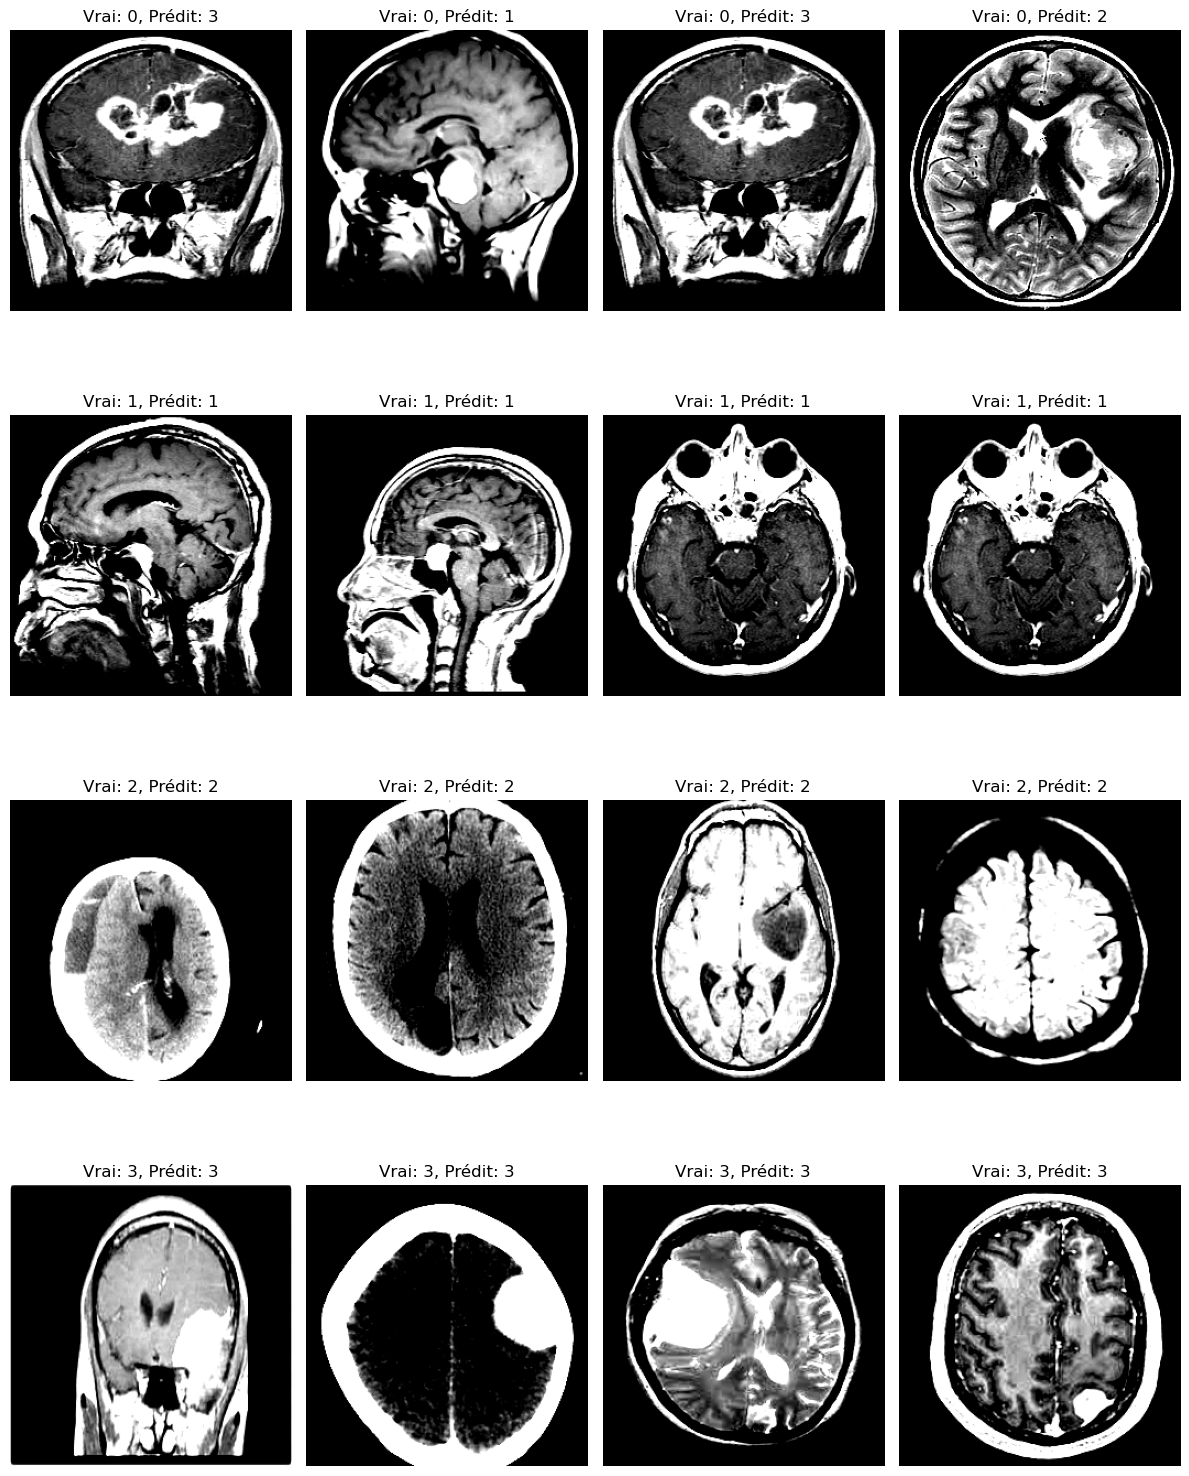

In [24]:
import numpy as np

#Obtenir les prédictions du modèle pour le dataset de test
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)  # Convertir les probabilités en labels

# Obtenir les vrais labels et les images
true_labels = []
images = []

for image, label in test_dataset:
    images.extend(image)  # Ajout des images
    true_labels.extend(label.numpy())  # Ajout des vrais labels en tant que tableau numpy

# Conversion en tableaux NumPy
true_labels = np.array(true_labels)
images = np.array(images)

# Fonction pour afficher des images avec les labels
def display_images_by_label(images, true_labels, predicted_labels, num_images=4):
    unique_labels = np.unique(true_labels)
    plt.figure(figsize=(12, num_images * len(unique_labels)))

    for label in unique_labels:
        # Sélectionner les indices où le vrai label correspond à la classe
        indices = np.where(true_labels == label)[0]
        
        # Afficher `num_images` par classe
        for i in range(num_images):
            index = indices[i] if i < len(indices) else indices[0]  # Assure qu'il y a assez d'images
            plt.subplot(len(unique_labels), num_images, label * num_images + i + 1)
            plt.imshow(images[index].squeeze(), cmap='gray' if images.shape[-1] == 1 else None)
            plt.title(f"Vrai: {true_labels[index]}, Prédit: {predicted_labels[index]}")
            plt.axis('off')

# Afficher les images avec les vrais labels et les labels prédits
display_images_by_label(images, true_labels, predicted_labels)
plt.tight_layout()
plt.show()

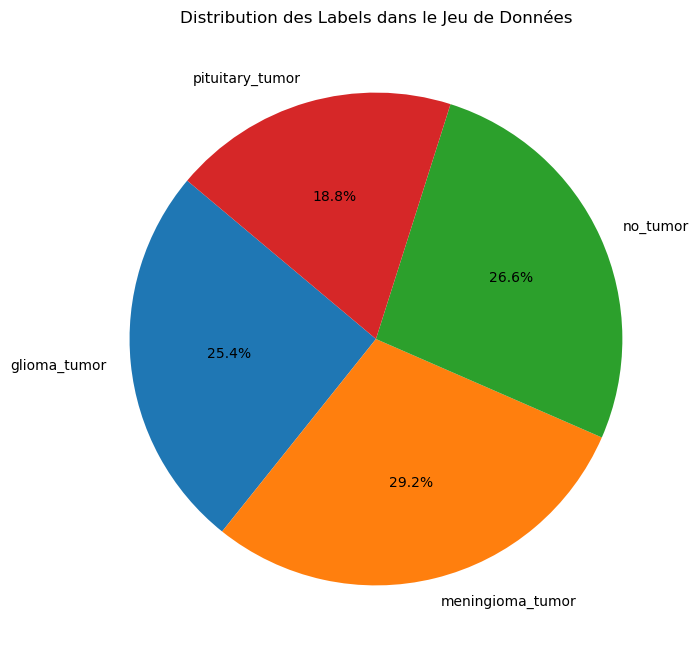

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter

# Compter les occurrences de chaque label dans le test_dataset
label_counts = Counter()

for _, label in test_dataset:
    label_counts[label.numpy()] += 1  # Incrémenter directement le compteur pour chaque label scalaire

# Mapper les codes numériques aux noms de labels
label_names = {0: 'glioma_tumor', 1: 'pituitary_tumor', 2: 'no_tumor', 3: 'meningioma_tumor'}
label_counts_named = {label_names.get(key, 'unknown'): value for key, value in label_counts.items()}

# Étape 2 : Préparer les données pour le graphique
labels = list(label_counts_named.keys())
sizes = list(label_counts_named.values())

# Création du camembert
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution des Labels dans le Jeu de Données')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
Classe 'glioma_tumor': 22.00% de prédictions correctes, 78.00% de prédictions incorrectes
Classe 'pituitary_tumor': 87.84% de prédictions correctes, 12.16% de prédictions incorrectes
Classe 'no_tumor': 99.05% de prédictions correctes, 0.95% de prédictions incorrectes
Classe 'meningioma_tumor': 95.65% de prédictions correctes, 4.35% de prédictions incorrectes


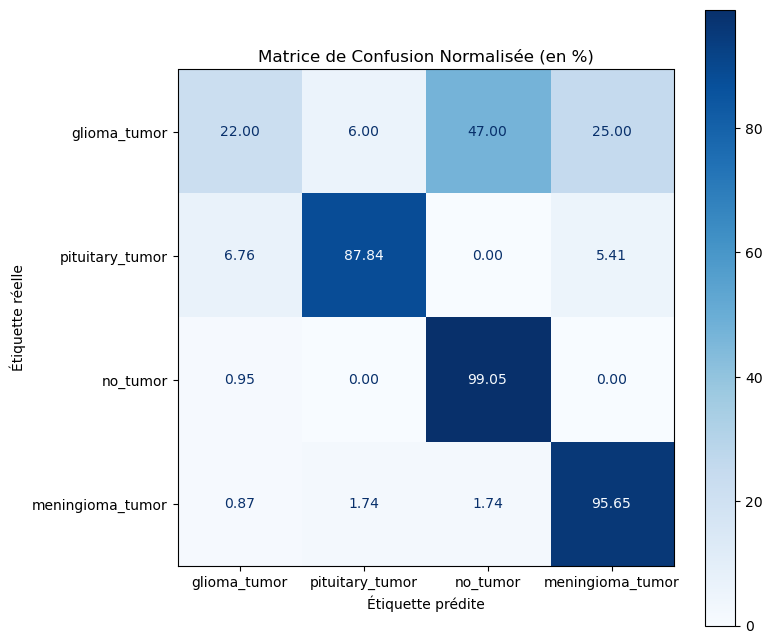

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Étape 1 : Extraire les vraies étiquettes et faire les prédictions
true_labels = []
pred_labels = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    true_labels.extend(labels.numpy())
    pred_labels.extend(predicted_classes)

# Étape 2 : Calculer la matrice de confusion
cm = confusion_matrix(true_labels, pred_labels)
class_names = ['glioma_tumor', 'pituitary_tumor', 'no_tumor', 'meningioma_tumor']

# Étape 3 : Normaliser la matrice pour obtenir les pourcentages par classe
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Pourcentage par ligne

# Étape 4 : Afficher la matrice de confusion avec les pourcentages
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Matrice de Confusion Normalisée (en %)")
plt.ylabel('Étiquette réelle')
plt.xlabel('Étiquette prédite')

# Étape 5 : Afficher les pourcentages de prédictions correctes et incorrectes par classe
correct_percentages = np.diag(cm_normalized)  # Pourcentage correct par classe (diagonale)
incorrect_percentages = 100 - correct_percentages  # Pourcentage incorrect par classe

for i, class_name in enumerate(class_names):
    print(f"Classe '{class_name}': {correct_percentages[i]:.2f}% de prédictions correctes, {incorrect_percentages[i]:.2f}% de prédictions incorrectes")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


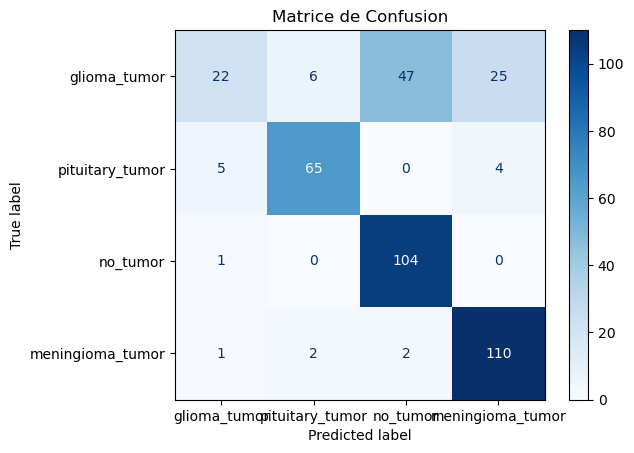

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Étape 1 : Extraire les vraies étiquettes et faire les prédictions
true_labels = []
pred_labels = []

for images, labels in test_dataset:
    # Prédictions du modèle sur le batch d'images
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)  # Classe prédite pour chaque image

    # Ajouter les labels vrais et prédits dans les listes
    true_labels.extend(labels.numpy())
    pred_labels.extend(predicted_classes)

# Étape 2 : Calculer la matrice de confusion
cm = confusion_matrix(true_labels, pred_labels)
class_names = ['glioma_tumor', 'pituitary_tumor', 'no_tumor', 'meningioma_tumor']  # Noms des classes

# Étape 3 : Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.show()
